# Bagged logistic regression

In [1]:
outfile = 'bagged_logistic_regression.csv'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

import numpy as np
import pandas as pd
from helper_methods import load_data
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

In [3]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

In [4]:
df_train, y_train, ids_train, features_set = load_data(train=True, engineering=True, standardizer=stdsc)

In [5]:
StatifiedCV = StratifiedKFold(y_train, n_folds=10, shuffle=True)

### Hyperparameter and feature set tuning

For each set of features, use stratified cross validation to find the optimal hyperparameters:

In [6]:
scores = []
lr = LogisticRegression()
clf = BaggingClassifier(base_estimator=lr)
param_grid = dict(n_estimators=[25, 50, 100, 200],
                  bootstrap_features=[True, False],
                  base_estimator__C=np.logspace(-3, 3, base=10, num=15),
                  base_estimator__penalty=['l1', 'l2'])
for i, features in enumerate(features_set):
    grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='log_loss', n_jobs=-1)
    grid.fit(X=df_train[features].values, y=y_train)
    scores.append((-grid.best_score_, i, grid.best_params_))
    print i, -grid.best_score_, grid.best_params_

0 0.489214600968 {'base_estimator__C': 2.6826957952797246, 'n_estimators': 50, 'base_estimator__penalty': 'l2', 'bootstrap_features': True}
1 0.496798872367 {'base_estimator__C': 2.6826957952797246, 'n_estimators': 25, 'base_estimator__penalty': 'l2', 'bootstrap_features': False}
2 0.48851125192 {'base_estimator__C': 138.94954943731361, 'n_estimators': 25, 'base_estimator__penalty': 'l1', 'bootstrap_features': True}
3 0.494834076613 {'base_estimator__C': 2.6826957952797246, 'n_estimators': 25, 'base_estimator__penalty': 'l1', 'bootstrap_features': False}
4 0.503125289831 {'base_estimator__C': 138.94954943731361, 'n_estimators': 50, 'base_estimator__penalty': 'l2', 'bootstrap_features': True}
5 0.496126056902 {'base_estimator__C': 51.794746792312125, 'n_estimators': 100, 'base_estimator__penalty': 'l2', 'bootstrap_features': True}
6 0.503197166604 {'base_estimator__C': 19.306977288832496, 'n_estimators': 50, 'base_estimator__penalty': 'l2', 'bootstrap_features': False}
7 0.487151802925 

### Set the optimal hyperparameters and feature set; refit the model to the entire training set

In [7]:
scores.sort()
optimal_features = features_set[scores[0][1]]
optimal_params = scores[0][2]
X_train = df_train[optimal_features].values
optimal_clf = clf.set_params(**optimal_params).fit(X_train, y_train)
print 'Optimal score: %.2f' % scores[0][0]
print 'Optimal features: ', optimal_features
print 'Optimal parameters: ', optimal_params

Optimal score: 0.48
Optimal features:  ['months_since_last', 'months_since_first', 'months_btwn_donation', 'inverse_first']
Optimal parameters:  {'base_estimator__C': 51.794746792312125, 'n_estimators': 25, 'base_estimator__penalty': 'l2', 'bootstrap_features': True}


### Load the test data, predict the probabilities and write to csv

In [8]:
df_test, y_dummy, ids_test, features_set_dummy = load_data(train=False, engineering=True, standardizer=stdsc)

In [9]:
X_test = df_test[optimal_features].values
y_pred_prob = optimal_clf.predict_proba(X_test)[:,1]
df_out = pd.DataFrame({'':ids_test, 'Made Donation in March 2007':y_pred_prob})
df_out.to_csv(outfile, index=False, header=True)

# Evaluation of the optimal classifier

### Learning curve

(0.3, 1)

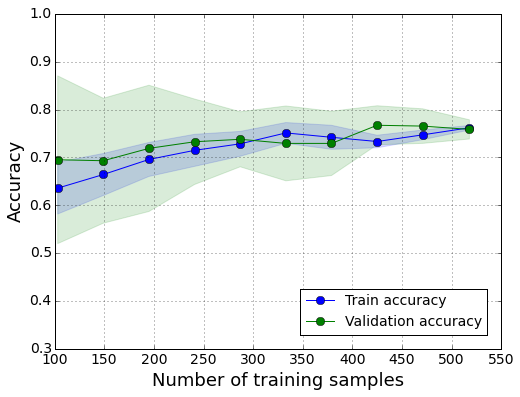

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores = learning_curve(optimal_clf, X_train, y_train, train_sizes=np.linspace(0.2, 1, 10), cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='b', marker='o', label='Train accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='b')
plt.plot(train_sizes, test_mean, color='g', marker='o', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.ylim(0.3, 1)

The learning curve for the optimal set of parameters and features is shown above. We see that the model is well fit. The shaded region indicate the standard deviation of the accuracy scores.

### Confusion matrix

In [11]:
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred_cv = cross_val_predict(optimal_clf, X_train, y_train, cv=StatifiedCV)
confmat = confusion_matrix(y_true=y_train, y_pred=y_train_pred_cv)
print confmat

[[435   3]
 [136   2]]


The function cross_val_predict has a similar interface to cross_val_score, but returns for each element in the input the prediction that was obtained for that element when it was in the test set. It does not offer a predict_proba method yet but this is under discussion.

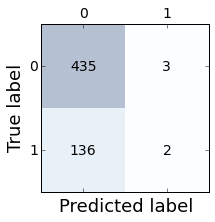

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')

### Metrics

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

print 'Accuracy:  %.2f' % accuracy_score(y_true=y_train, y_pred=y_train_pred_cv)
print 'Recall:    %.2f' % recall_score(y_true=y_train, y_pred=y_train_pred_cv)
print 'Precision: %.2f' % precision_score(y_true=y_train, y_pred=y_train_pred_cv)
print 'F1 score:  %.2f' % f1_score(y_true=y_train, y_pred=y_train_pred_cv)
print 'Log loss:  %.2f' % log_loss(y_true=y_train, y_pred=y_train_pred_cv)

Accuracy:  0.76
Recall:    0.01
Precision: 0.40
F1 score:  0.03
Log loss:  8.33


### Permutation test score

In order to test if a classification score is significant, a technique in repeating the classification procedure after randomizing, permuting, the labels. The p-value is then given by the percentage of runs for which the score obtained is greater than the classification score obtained in the first place.

(0.45, 0.8)

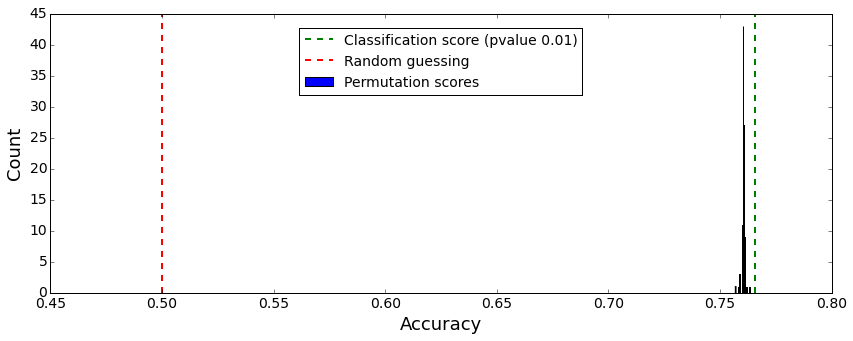

In [14]:
from sklearn.cross_validation import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(optimal_clf, X_train, y_train, cv=StatifiedCV, n_permutations=100, scoring='accuracy')
plt.figure(figsize=(14,5))
plt.hist(permutation_scores, 20, label='Permutation scores')
plt.plot(2 * [score], plt.ylim(), '--g', linewidth=2, label='Classification score (pvalue {:.2f})'.format(pvalue))
plt.plot(2 * [1. / 2], plt.ylim(), '--r', linewidth=2, label='Random guessing')
plt.legend(loc='upper center')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xlim(0.45, 0.8)